# Hyperparameter tuning

Depending on the structure, neural networks can have hundreds, thousands or even millions of parameters, e.g. the weights of dense layers or convolutional kernels, which are optimized during the training process. The exact number of network parameters is controlled by so-called hyperparameters such as the number of nodes, for which no such optimization algorithm has been discussed yet. Luckily, ```keras``` provides a library called ```kerastuner``` which allows us to include parameter ranges into our network definitions, which can then be optimized to find the best-performing combination of hyperparameters. First, you need to install ```kerastuner``` into your ```tensorflow``` environment by executing
```
pip install keras-tuner 
```
in the Anaconda prompt. We can then import the library into a notebook alongside other relevant packages:

In [1]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

2024-01-10 04:21:18.627547: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-10 04:21:18.656003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 04:21:18.656024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 04:21:18.656633: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 04:21:18.660741: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-10 04:21:18.661058: I tensorflow/core/platform/cpu_feature_guard.cc:1

In this example, we will be using the classic MNIST dataset of handwritten digits. If you are lazy, you can download the data using ```keras```:

In [2]:
(img_train, label_train), (img_test, label_test) = keras.datasets.mnist.load_data()
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

11490434/11490434 [==============================] - 1s 0us/step


In order to optimize your network hyperparameters, ```keras-tuner``` requires you to provide a function that returns a model (or work with subclasses). As sole argument, we provide a hyperparameter object ```hyper``` that contains the parameter space within which your network will be optimized. In the function, you can define tunable parameters using ```Int``` to define integer ranges of values (including the upper bound), ```Float``` for float range of values, ```Choice``` to have ```keras-tuner``` find the best value within a list of values, or ```Boolean``` for, e.g. including a dropout layer or not. For all of them, you need to provide a hyperparameter label. After defining your hyperparameter labels, just pass the appropriate hyperparameter object as arguments:

In [3]:
def modelBuilder(hyper):
    # Define tunable hyperparameter objects
    hyperNodes = hyper.Int('nodes', min_value=32, max_value=512, step=16)
    hyperLrate = hyper.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.Dense(units=hyperNodes, activation='relu'),
        keras.layers.Dense(10, activation='softmax')])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hyperLrate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])

    return model

Next, we need to define a tuner that performs the optimization. You can select from several options, ```hyperband``` is a good start. As arguments, we pass the objective (optimize the validation accuracy), the maximum number of training epochs, the buffer output directory path and a project name. If you're running this notebook on a Windows machine, you further want to uncomment lines 2 and 3 to avoid issues that can arise from excessivly long directory paths:

In [4]:
folder = "mnist"
# If you're running this notebook under windows, you may have to uncomment these two lines
#from os.path import normpath
#folder = normpath("C:/")

nEpochs = 30
tuner = kt.Hyperband(modelBuilder,objective='val_accuracy',
                     max_epochs=nEpochs,factor=3,
                     directory=folder,
                     project_name="mnist")

2024-01-10 04:22:06.346953: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-10 04:22:06.347494: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


The syntax to start the hyperparameter search corresponds to the already known ```fit``` method. The best-fit hyperparameters will be written into the ``hyperBest`` object:

In [5]:
tuner.search(img_train, label_train, epochs=nEpochs, validation_data=(img_test, label_test), verbose=1)
hyperBest = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 90 Complete [00h 01m 23s]
val_accuracy: 0.9811999797821045

Best val_accuracy So Far: 0.984000027179718
Total elapsed time: 00h 31m 56s


That can take quite some time, especially if you don't have a powerful GPU in your machine ... once it's through, we can take a look at the best-fit parameters found by ```keras-tuner``` using the ```values``` method which returns a dictionary:

In [6]:
print("Optimal hyperparameters:")
for key in hyperBest.values:
    print(key, hyperBest.values[key])

Optimal hyperparameters:
nodes 400
learning_rate 0.001
tuner/epochs 30
tuner/initial_epoch 10
tuner/bracket 2
tuner/round 2
tuner/trial_id 0070


Using these parameters, we can build and train the model:

In [7]:
model = tuner.hypermodel.build(hyperBest)
history = model.fit(img_train, label_train, epochs=nEpochs, validation_data=(img_test, label_test), verbose=True)

Epoch 1/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2083 - accuracy: 0.9397 - val_loss: 0.1056 - val_accuracy: 0.9683
Epoch 2/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0825 - accuracy: 0.9755 - val_loss: 0.0765 - val_accuracy: 0.9762
Epoch 3/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0549 - accuracy: 0.9830 - val_loss: 0.0678 - val_accuracy: 0.9784
Epoch 4/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0381 - accuracy: 0.9882 - val_loss: 0.0726 - val_accuracy: 0.9784
Epoch 5/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0297 - accuracy: 0.9904 - val_loss: 0.0705 - val_accuracy: 0.9800
Epoch 6/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0215 - accuracy: 0.9930 - val_loss: 0.0761 - val_accuracy: 0.9792
Epoch 7/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0170 - accuracy: 0.9942 - val_loss: 0.0797 - val_accuracy:

Let's check the network's performance:

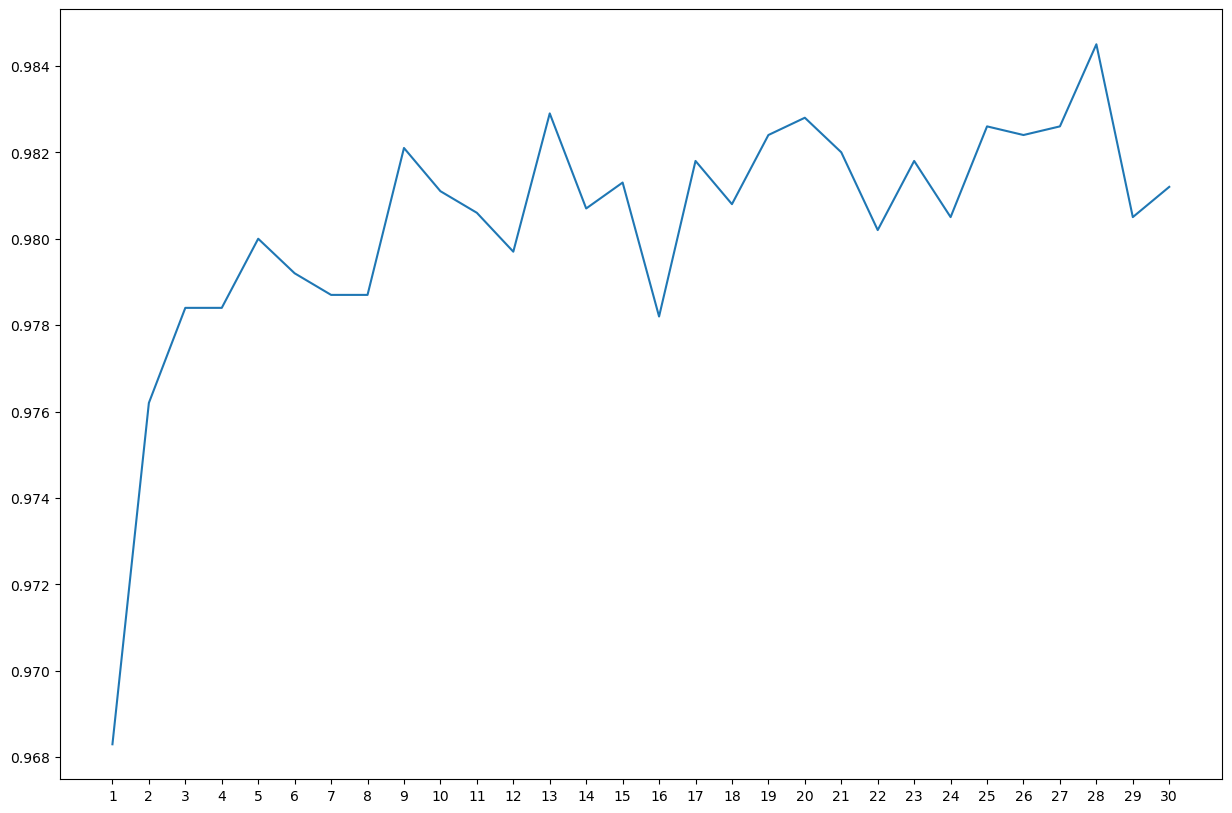

In [8]:
import matplotlib.pyplot as plt

valAccEvo = history.history['val_accuracy']
i = list(range(1,nEpochs+1))

plt.figure(figsize=(15,10))
plt.plot(i,valAccEvo)
plt.xticks(i)
plt.show()